In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
#from wordcloud import WordCloud

In [7]:
import pickle
dee = open('combine_df_prepocessed.pkl','rb')
combine_df = pickle.load(dee)
dee.close()
combine_df.head(2)

,id,label,tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee..."


In [8]:
print(combine_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 7 columns):
id                      49159 non-null int64
label                   31962 non-null float64
tweet                   49159 non-null object
tweet_token             49159 non-null object
tweet_token_filtered    49159 non-null object
tweet_stemmed           49159 non-null object
tweet_lemmatized        49159 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 2.6+ MB
None


In [4]:
#-----------------------------------------------------------------------------------------------
#
#
#
#Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
#- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
#- Ответами является столбец train_df['label']
#- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
#- Рассчитаем f1_score 

#Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [5]:
train_df = combine_df[:31962]
test_df = combine_df[31962:]

In [6]:
combine_df['tweet_stemmed'].head(2)

0    [father, dysfunct, selfish, drag, kid, dysfunc...
1    [thank, lyft, credit, use, caus, offer, wheelc...
Name: tweet_stemmed, dtype: object

In [7]:
combine_df['tweet_lemmatized'].head(2)

0    [father, dysfunctional, selfish, drag, kid, dy...
1    [thanks, lyft, credit, use, cause, offer, whee...
Name: tweet_lemmatized, dtype: object

1. Создайте мешок слов с помощью sklearn.feature_extraction.text.CountVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.
●	Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
●	Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
●	Исключим стоп-слова с помощью stop_words='english'.
●	Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью CountVectorizer.get_feature_names().


In [25]:
train_y = train_df['label'].fillna(0).astype(int)
valid_y = test_df['label'].fillna(0).astype(int)

In [26]:
documents_train = train_df['tweet_stemmed'].apply(lambda x: " ".join(x))
documents_valid = test_df['tweet_stemmed'].apply(lambda x: " ".join(x))

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vectorizer = CountVectorizer(max_df=0.9, max_features=1000, stop_words='english')

# Создаем the Bag-of-Words модель
xtrain_count = count_vectorizer.fit_transform(documents_train)
xvalid_count = count_vectorizer.fit_transform(documents_valid)

# Отобразим Bag-of-Words модель как DataFrame
feature_names = count_vectorizer.get_feature_names()
pd.DataFrame(xtrain_count[:10].toarray(), columns = feature_names)

,abl,absolut,abt,abus,accept,account,act,action,activ,actor,...,yeah,year,yesterday,yo,yoga,york,young,youtub,yr,yummi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [30]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(class_weight="balanced"), xtrain_count, train_y, xvalid_count, valid_y)
print("LR, Count Vectors: ", accuracy)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, Count Vectors:  0.7750188986451125


In [31]:
documents_train = train_df['tweet_lemmatized'].apply(lambda x: " ".join(x))
documents_valid = test_df['tweet_lemmatized'].apply(lambda x: " ".join(x))

In [32]:
# Создаем the Bag-of-Words модель
xtrain_count = count_vectorizer.fit_transform(documents_train)
xvalid_count = count_vectorizer.fit_transform(documents_valid)

In [33]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(class_weight="balanced"), xtrain_count, train_y, xvalid_count, valid_y)
print("LR, Count Vectors: ", accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, Count Vectors:  0.7898470663487818


2. Создайте мешок слов с помощью sklearn.feature_extraction.text.TfidfVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.
●	Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
●	Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
●	Исключим стоп-слова с помощью stop_words='english'.
●	Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью TfidfVectorizer.get_feature_names().


In [56]:
documents_train = train_df['tweet_stemmed'].apply(lambda x: " ".join(x))
documents_valid = test_df['tweet_stemmed'].apply(lambda x: " ".join(x))

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=1000, stop_words='english')

# Создаем the Bag-of-Words модель
xtrain_tfidf = tfidf_vectorizer.fit_transform(documents_train)
xvalid_tfidf = tfidf_vectorizer.fit_transform(documents_valid)

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
pd.DataFrame(xtrain_tfidf[:10].toarray(), columns = feature_names)

,abl,absolut,abt,abus,accept,account,act,action,activ,actor,...,yeah,year,yesterday,yo,yoga,york,young,youtub,yr,yummi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.404743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(class_weight="balanced"), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("LR, WordLevel TF-IDF Vectors: ", accuracy)

LR, WordLevel TF-IDF Vectors:  0.797871721811944


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
documents_train = train_df['tweet_lemmatized'].apply(lambda x: " ".join(x))
documents_valid = test_df['tweet_lemmatized'].apply(lambda x: " ".join(x))

In [60]:
# Создаем the Bag-of-Words модель
xtrain_tfidf = tfidf_vectorizer.fit_transform(documents_train)
xvalid_tfidf = tfidf_vectorizer.fit_transform(documents_valid)

In [61]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(class_weight="balanced"), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("LR, WordLevel TF-IDF Vectors: ", accuracy)

LR, WordLevel TF-IDF Vectors:  0.8249694714194337


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Вывод: "tweet_lemmatized" работает лучше. Метод векторизации "WordLevel TF-IDF" работет лучше, чем "Count Vectors".
    Лучший результат accuracy для WordLevel TF-IDF Vectors:  0.825 
    

In [ ]:
#Задание 4.
#Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
#Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
#- объединим слова в одну строку
#- создадим словарь частот слов с помощью collections.Counter
#- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
#- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова


In [4]:
!pip install WordCloud

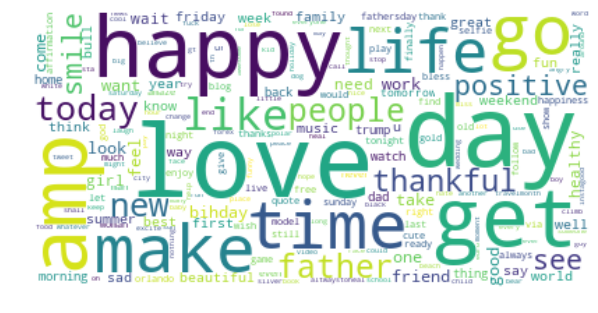

In [10]:
import collections
from wordcloud import WordCloud
from nltk.corpus import stopwords

words = []
for line_words in combine_df['tweet_lemmatized']: 
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

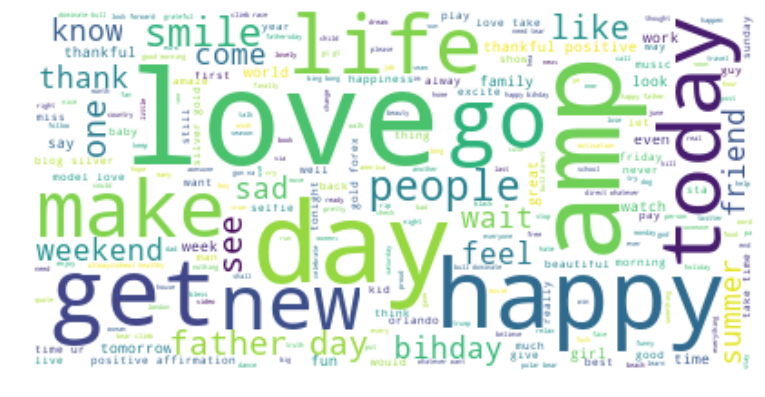

In [12]:
pos_words = []
for line_words in combine_df['tweet_lemmatized'][combine_df['label']==0.0]: 
    pos_words.extend(line_words)
pos_words = ' '.join(pos_words)

stopwords_set = set(stopwords.words('english'))
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=50000,
    stopwords = stopwords_set
   ).generate(pos_words)
plt.figure(figsize=(13,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

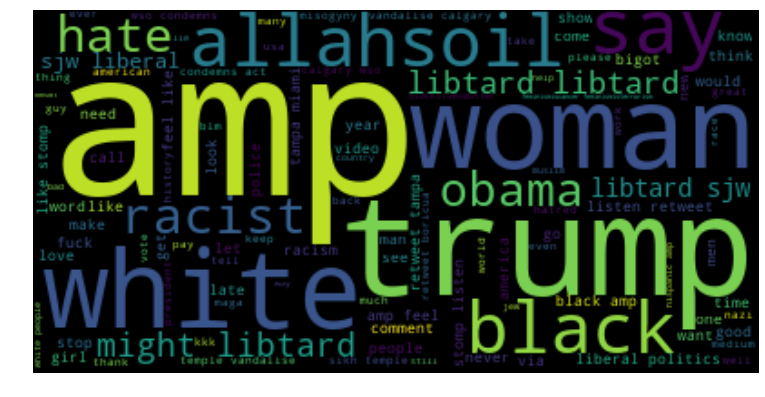

In [20]:
neg_words = []
for line_words in combine_df['tweet_lemmatized'][combine_df['label']==1.0]: 
    neg_words.extend(line_words)
neg_words = ' '.join(neg_words)

stopwords_set = set(stopwords.words('english'))
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='black',
    max_words=50000,
    stopwords = stopwords_set
   ).generate(neg_words)
plt.figure(figsize=(13,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()